In [1]:
import json
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import precision_score, roc_auc_score, confusion_matrix, classification_report, average_precision_score
import seaborn as sb
import matplotlib.pyplot as plt

np.random.seed(503)

In [2]:
target_name = 'RegisteredInTargetPeriod'

# Decide whether we're loading a subset or the full set
dataset_size = 'partial'
# dataset_size = 'full'

if dataset_size == 'full':
    file_names = {
        'X': 'X_holdout_full.csv',
        'y': 'y_holdout_full.csv',
        'model': '../../models/classifier_full.pkl'
        # 'model': '../../models/logistic_full.pkl'
        # 'model': '../../models/xgboost_full.pkl'
    }
elif dataset_size == 'partial':
    file_names = {
        'X': 'X_holdout.csv',
        'y': 'y_holdout.csv',
        'model': '../../models/classifier.pkl'
        # 'model': '../../models/logistic.pkl'
        # 'model': '../../models/xgboost.pkl'
    }

In [3]:
# Load data
with open('../../data/processed/dtypes.json') as in_file:
    non_date_dtypes = json.load(in_file)

with open('../../data/processed/date_types.json') as in_file:
    date_dtypes = json.load(in_file)

date_cols = list(date_dtypes)

# Read data, specifically parsing date columns as dates and only picking the features + target
X_test = pd.read_csv('../../data/processed/{0}'.format(file_names['X']), dtype=non_date_dtypes, index_col=0)
y_test = pd.read_csv('../../data/processed/{0}'.format(file_names['y']), index_col=0)

In [4]:
# Load model
clf = joblib.load(file_names['model'])

In [5]:
# Score model
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.2s finished


0.6816250663834307
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    424654
           1       0.68      0.13      0.22     39621

    accuracy                           0.92    464275
   macro avg       0.80      0.56      0.59    464275
weighted avg       0.90      0.92      0.89    464275



In [6]:
# Get average precision
average_precision_score(y_test, y_pred)

0.1626048483761427

In [7]:
# Calculate predicted probabilities
y_pred_prob = clf.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.2s finished


In [8]:
# Combine target with predicted probability of registration
pred_probs = y_pred_prob[:, 1]  # Prediction of positive target
y_with_probs = y_test.reset_index().merge(pd.Series(pred_probs).rename('PredictedProbabilityOfRegistration'), left_index=True, right_index=True).set_index('index')
y_with_probs.index.name = None

# Combine with original feature set (X) to create a scored dataset
scored_data = X_test.merge(y_with_probs, left_index=True, right_index=True)

# Sort in place for quantiles
scored_data.sort_values(by='PredictedProbabilityOfRegistration', ascending=False, inplace=True)

# Assign quantiles
scored_data['Quantile'] = pd.qcut(-scored_data['PredictedProbabilityOfRegistration'], 10, labels=False)

In [9]:
# Look at means by attribute
scored_data.groupby('Quantile').mean()

,DaysSinceLastRegistration,DaysSinceFirstRegistration,PastRegistrations,LastDonationLocation_Center,LastDonationType_Platelets,CenterRegistrationProportion,DonationsPerDay,PlateletRegistrationProportion,RegisteredInTargetPeriod,PredictedProbabilityOfRegistration
Quantile,,,,,,,,,,
0,69.589644,1100.073167,13.669531,0.473357,0.124946,0.462997,0.013253,0.115092,0.346343,0.355465
1,109.642062,918.023262,6.289357,0.276606,0.034570,0.282148,0.008197,0.036292,0.143322,0.151401
2,140.734880,856.814336,4.860601,0.175304,0.024877,0.179353,0.006775,0.026297,0.091798,0.101578
3,154.990253,741.070834,3.704355,0.117034,0.019090,0.119480,0.006443,0.019583,0.071218,0.075234
4,176.547345,700.012769,2.994083,0.079985,0.015205,0.082410,0.006768,0.015088,0.055122,0.058885
5,160.191996,534.804364,2.043745,0.053201,0.012902,0.056358,0.007440,0.012963,0.042539,0.046446
6,163.880498,404.276117,1.594042,0.038836,0.007948,0.038920,0.007821,0.007655,0.034679,0.037900
7,176.747790,343.609524,1.355477,0.030963,0.006748,0.030741,0.006893,0.006493,0.028550,0.031507
8,230.628348,315.977779,1.163421,0.037994,0.011035,0.038059,0.005391,0.009673,0.023346,0.024516


In [10]:
scored_data.groupby('Quantile').mean().to_csv('../../data/summary/holdout_mean_features.csv')

[Text(0, 0.5, 'Donations')]

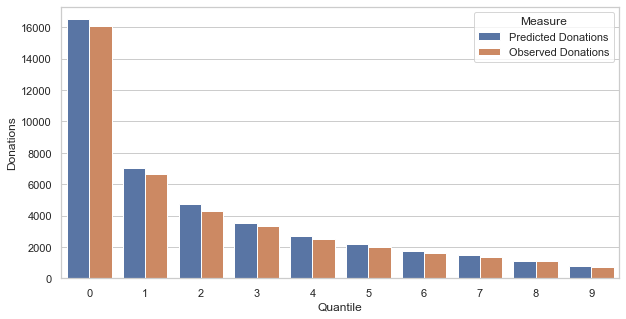

In [11]:
sb.set(style='whitegrid', rc={'figure.figsize': (10, 5)})

# Calculate stats for each quantile: total actual registrations, total donors, and mean predicted probability
quantile_stats = scored_data.groupby('Quantile').agg({target_name: ['count', 'sum'], 'PredictedProbabilityOfRegistration': ['sum', 'mean']})

# Rename columns
quantile_stats.columns = ['Total In Quantile', 'Observed Donations', 'Predicted Donations', 'Mean Predicted Probability']

# Just get the two variables we care about
quantile_stats['Observed Probability'] = quantile_stats['Observed Donations'] / quantile_stats['Total In Quantile']
quantile_stats.reset_index(inplace=True)
# quantile_stats.drop(['ActualRegistered', 'TotalInQuantile'], axis=1, inplace=True)

quantile_stats

# Melt so we can plot mean predicted probability and actual % registered together
melted_quantile_stats = pd.melt(quantile_stats, id_vars='Quantile', var_name='Measure', value_name='Value')

sb.set(style='whitegrid')
ax = sb.barplot(x='Quantile', y='Value', hue='Measure', data=melted_quantile_stats[melted_quantile_stats['Measure'].isin(('Predicted Donations', 'Observed Donations'))], hue_order=['Predicted Donations', 'Observed Donations'])
ax.set(ylabel='Donations')

[Text(0, 0.5, 'Registrations')]

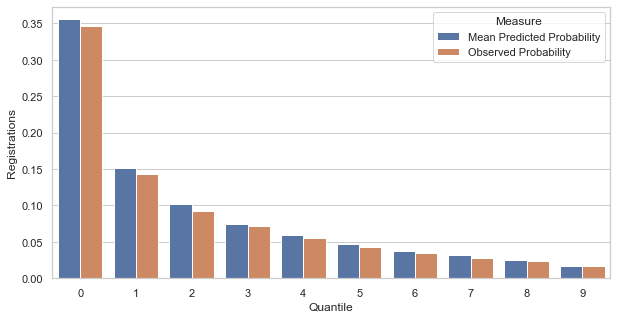

In [12]:
ax = sb.barplot(x='Quantile', y='Value', hue='Measure', data=melted_quantile_stats[melted_quantile_stats['Measure'].isin(('Mean Predicted Probability', 'Observed Probability'))])
ax.set(ylabel='Registrations')

In [13]:
# Calculate percent errors for quantile probabilities
quantile_stats['Probability Error'] = np.abs(quantile_stats['Mean Predicted Probability'] - quantile_stats['Observed Probability']) / quantile_stats['Observed Probability']
quantile_stats

,Quantile,Total In Quantile,Observed Donations,Predicted Donations,Mean Predicted Probability,Observed Probability,Probability Error
0,0,46428,16080,16503.548386,0.355465,0.346343,0.026340
1,1,46427,6654,7029.090761,0.151401,0.143322,0.056371
2,2,46428,4262,4716.052868,0.101578,0.091798,0.106535
3,3,46884,3339,3527.259133,0.075234,0.071218,0.056382
4,4,45971,2534,2706.999770,0.058885,0.055122,0.068271
5,5,46428,1975,2156.394229,0.046446,0.042539,0.091845
6,6,46426,1610,1759.564671,0.037900,0.034679,0.092897
7,7,46830,1337,1475.460276,0.031507,0.028550,0.103560
8,8,46218,1079,1133.079298,0.024516,0.023346,0.050120
9,9,46235,751,795.447263,0.017204,0.016243,0.059184


In [14]:
quantile_stats['Probability Error'].mean()

0.07115061066891606

In [15]:
# Calculate total predicted registrations
predicted_registrations = sum(scored_data['PredictedProbabilityOfRegistration'])
print(f"Predicted registrations: {predicted_registrations}")

Predicted registrations: 41802.89665561113


In [16]:
# Calculate total actual registrations
actual_registrations = sum(scored_data['RegisteredInTargetPeriod'])
print(f"Observed registrations: {actual_registrations}")

Observed registrations: 39621


In [17]:
# Calculate error for estimation
np.abs(predicted_registrations - actual_registrations) / actual_registrations

0.05506919703215804

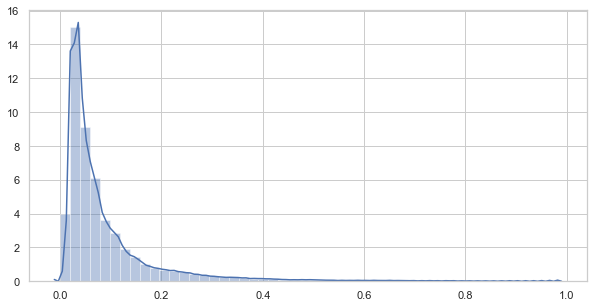

In [18]:
sb.distplot(pred_probs)

# Plot characteristics of each quantile

In [19]:
sb.set(style='whitegrid', rc={'figure.figsize': (10, 5)})

[Text(0, 0.5, 'Predicted Probability Of Registration'),
 Text(0.5, 1.0, 'Distribution of Predicted Probability by Quantile')]

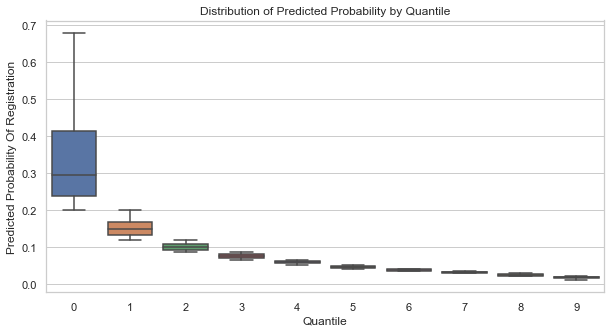

In [20]:
# Plot predicted probability
ax = sb.boxplot(x='Quantile', y='PredictedProbabilityOfRegistration', data=scored_data, showfliers=False)
ax.set(ylabel='Predicted Probability Of Registration', title='Distribution of Predicted Probability by Quantile')

[Text(0, 0.5, 'Days Since Last Registration'),
 Text(0.5, 1.0, 'Distribution of Recency by Quantile')]

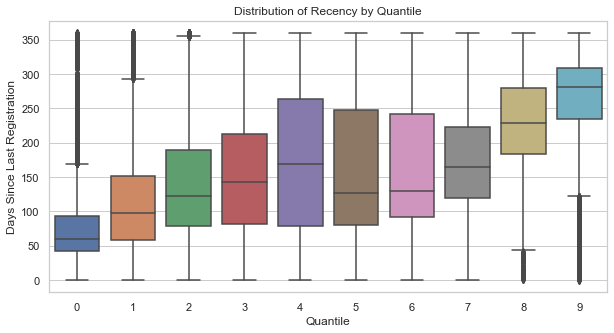

In [21]:
# Plot Recency
ax = sb.boxplot(x='Quantile', y='DaysSinceLastRegistration', data=scored_data)
ax.set(ylabel='Days Since Last Registration', title='Distribution of Recency by Quantile')

[Text(0, 0.5, 'Days Since First Registration'),
 Text(0.5, 1.0, 'Distribution of Donor "Age" by Quantile')]

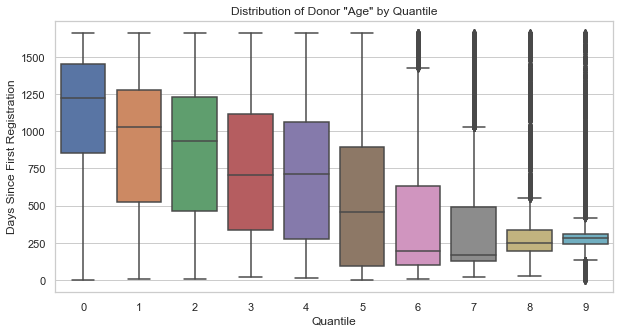

In [22]:
# Plot Time
ax = sb.boxplot(x='Quantile', y='DaysSinceFirstRegistration', data=scored_data)
ax.set(ylabel='Days Since First Registration', title='Distribution of Donor "Age" by Quantile')

[Text(0, 0.5, 'Past Registration'),
 Text(0.5, 1.0, 'Distribution of Past Registrations by Quantile')]

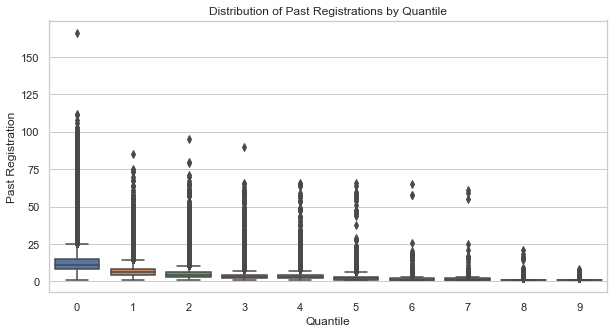

In [23]:
# Plot Frequency box plot
ax = sb.boxplot(x='Quantile', y='PastRegistrations', data=scored_data)
ax.set(ylabel='Past Registration', title='Distribution of Past Registrations by Quantile')

[Text(0, 0.5, 'Mean Days Since Last Registration')]

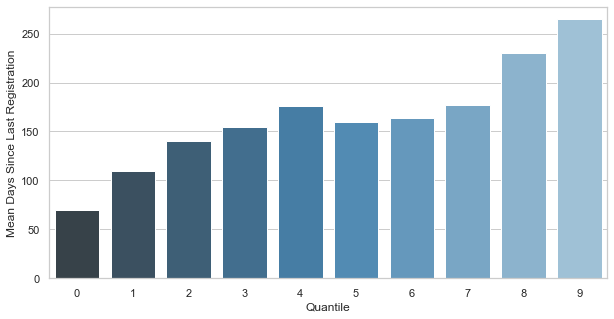

In [24]:
# Plot mean Recency
sb.set_palette('Blues_d', n_colors=10)
ax = sb.barplot(x='Quantile', y='DaysSinceLastRegistration', data=scored_data.groupby('Quantile', as_index=False).mean())
ax.set(ylabel='Mean Days Since Last Registration')

[Text(0, 0.5, 'Mean Past Registrations')]

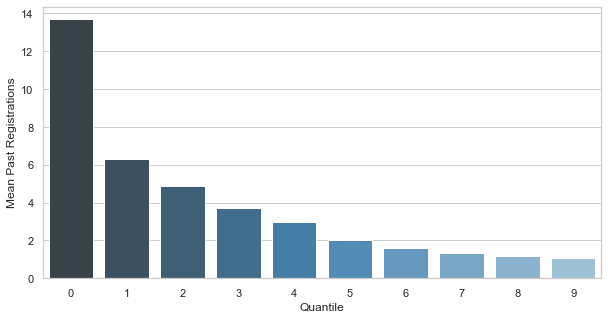

In [25]:
# Plot mean Frequency
sb.set_palette('Blues_d', n_colors=10)
ax = sb.barplot(x='Quantile', y='PastRegistrations', data=scored_data.groupby('Quantile', as_index=False).mean())
ax.set(ylabel='Mean Past Registrations')

[Text(0, 0.5, 'Mean Days Since First Registrations')]

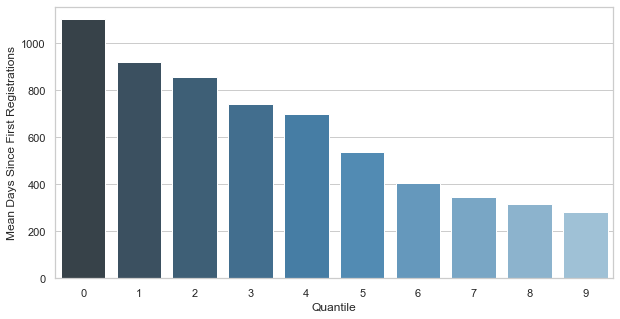

In [26]:
# Plot mean Time
sb.set_palette('Blues_d', n_colors=10)
ax = sb.barplot(x='Quantile', y='DaysSinceFirstRegistration', data=scored_data.groupby('Quantile', as_index=False).mean())
ax.set(ylabel='Mean Days Since First Registrations')